**Anomaly Detection in Time Series Data**

In [7]:
from pymongo import MongoClient
from dotenv import load_dotenv
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load environment variables from .env file
load_dotenv()

# Get MongoDB connection details from environment variables
mongo_uri = os.getenv("MONGO_URI")
mongo_db = os.getenv("MONGO_DB")
mongo_collection = os.getenv("MONGO_ENERGY_COLLECTION")

# Connect to MongoDB and fetch data
client = MongoClient(mongo_uri)
db = client[mongo_db]
collection = db[mongo_collection]

# Fetch only 'energy_kwh' and 'timestamp' columns
data = list(collection.find({}, {"_id": 0, "energy_kwh": 1, "timestamp": 1}))

# Convert to DataFrame
df = pd.DataFrame(data)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2885 entries, 0 to 2884
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   timestamp   2885 non-null   datetime64[ns]
 1   energy_kwh  2885 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 45.2 KB


In [8]:
df.describe()

,timestamp,energy_kwh
count,2885,2885.000000
mean,2025-04-11 13:16:41.557999872,4.346236
min,2025-03-27 12:46:41.558000,2.400000
25%,2025-04-04 01:01:41.558000128,2.730000
50%,2025-04-11 13:16:41.558000128,3.420000
75%,2025-04-19 01:31:41.558000128,6.150000
max,2025-04-26 13:46:41.558000,9.450000
std,NaN,1.965917


In [9]:
df.head()

,timestamp,energy_kwh
0,2025-03-27 12:46:41.558,2.85
1,2025-03-27 13:01:41.558,2.85
2,2025-03-27 13:16:41.558,3.00
3,2025-03-27 13:31:41.558,2.94
4,2025-03-27 13:46:41.558,2.79


Missing values:
 timestamp     0
energy_kwh    0
dtype: int64

Number of duplicate rows: 0


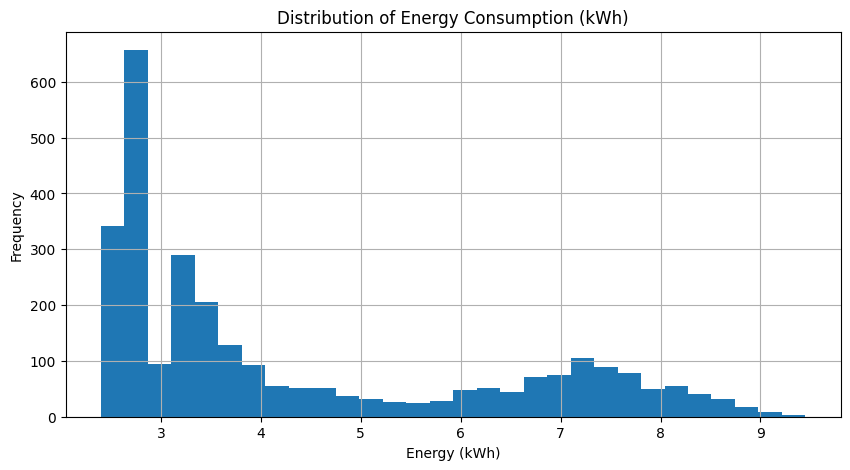


Time range:
Start: 2025-03-27 12:46:41.558000
End: 2025-04-26 13:46:41.558000


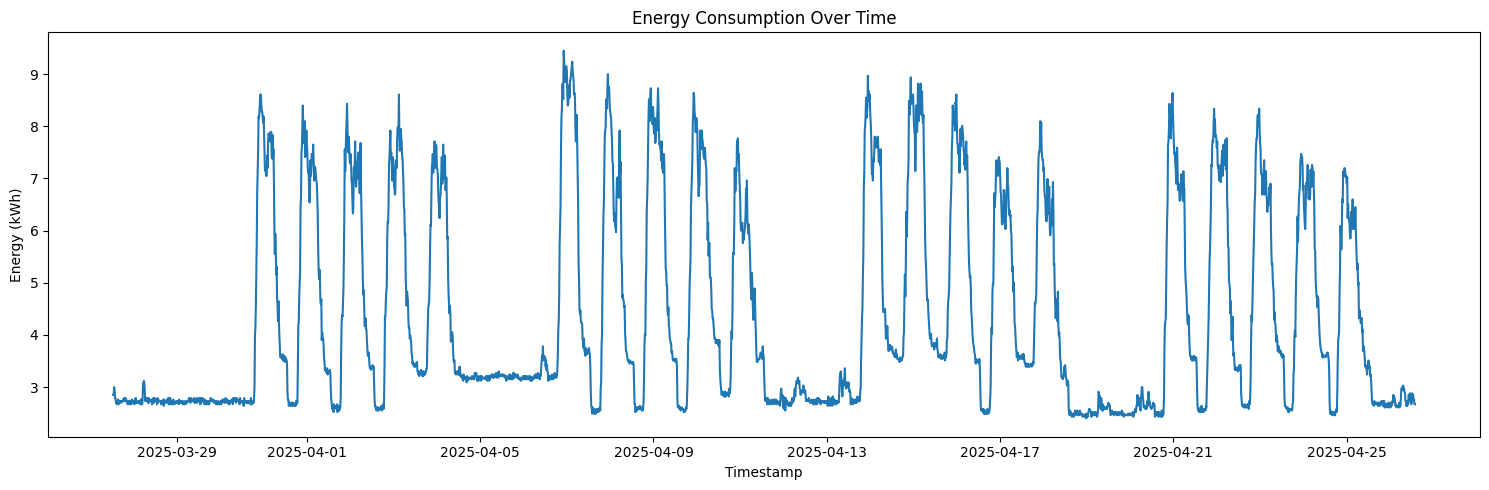


Basic statistics for energy_kwh:
count    2885.000000
mean        4.346236
std         1.965917
min         2.400000
25%         2.730000
50%         3.420000
75%         6.150000
max         9.450000
Name: energy_kwh, dtype: float64


In [10]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)

# Check for duplicates
duplicates = df.duplicated().sum()
print("\nNumber of duplicate rows:", duplicates)

# Distribution of energy_kwh
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
df['energy_kwh'].hist(bins=30)
plt.title('Distribution of Energy Consumption (kWh)')
plt.xlabel('Energy (kWh)')
plt.ylabel('Frequency')
plt.show()

# Time range of the data
print("\nTime range:")
print("Start:", df['timestamp'].min())
print("End:", df['timestamp'].max())

# Plot energy consumption over time
plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'], df['energy_kwh'])
plt.title('Energy Consumption Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Energy (kWh)')
plt.tight_layout()
plt.show()

# Basic statistics
print("\nBasic statistics for energy_kwh:")
print(df['energy_kwh'].describe())

<Figure size 1200x600 with 0 Axes>

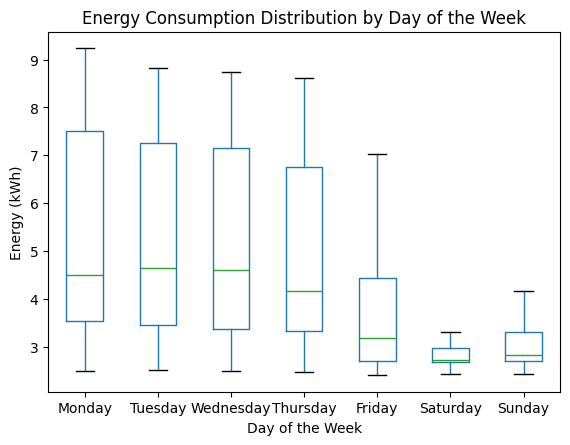

In [12]:
# The 'order' argument is not supported in pandas' boxplot.
# To control the order, set 'day_of_week' as a categorical type with the desired order.

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=days_order, ordered=True)

plt.figure(figsize=(12, 6))
df.boxplot(column='energy_kwh', by='day_of_week', grid=False, showfliers=False)
plt.title('Energy Consumption Distribution by Day of the Week')
plt.suptitle('')
plt.xlabel('Day of the Week')
plt.ylabel('Energy (kWh)')
plt.show()

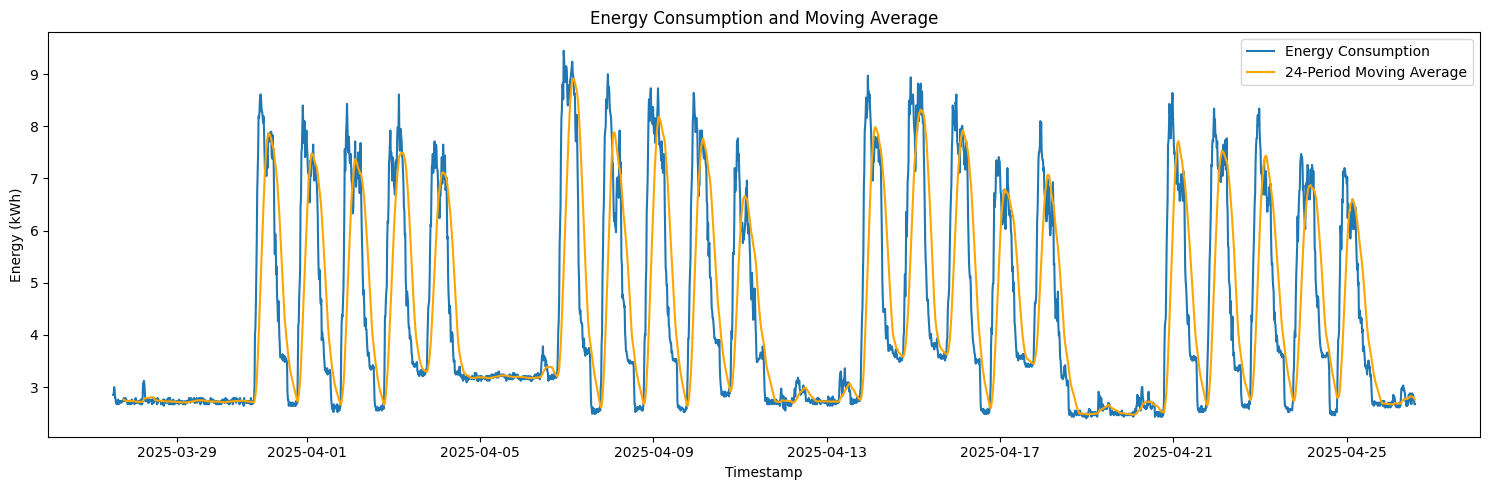

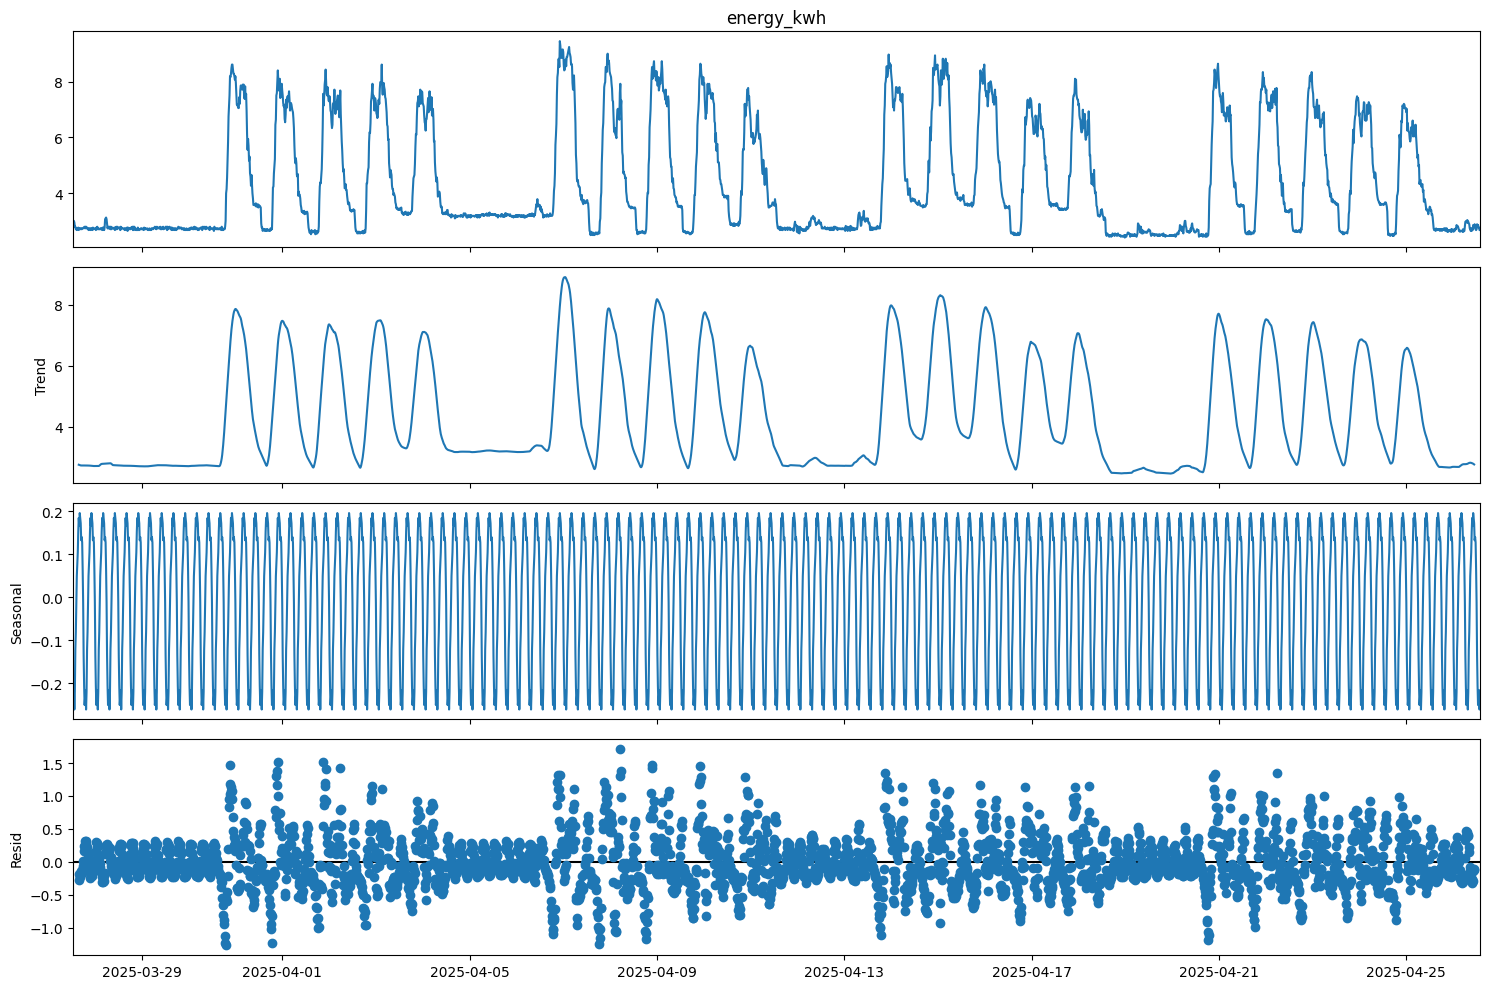

ADF Statistic: -9.963991295212095
p-value: 2.3331423737006423e-17
Critical Value (1%): -3.432640929340317
Critical Value (5%): -2.862552176016622
Critical Value (10%): -2.567308811060259

The time series is likely stationary (reject H0).

Summary statistics:
count    2885.000000
mean        4.346236
std         1.965917
min         2.400000
25%         2.730000
50%         3.420000
75%         6.150000
max         9.450000
Name: energy_kwh, dtype: float64

Skewness: 0.8743109036470075
Kurtosis: -0.755612810620514


In [13]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure the data is sorted by timestamp
df = df.sort_values('timestamp')

# Set timestamp as index for time series analysis
df_ts = df.set_index('timestamp')

# Plot the time series and moving average
plt.figure(figsize=(15, 5))
plt.plot(df_ts['energy_kwh'], label='Energy Consumption')
plt.plot(df_ts['energy_kwh'].rolling(window=24).mean(), label='24-Period Moving Average', color='orange')
plt.title('Energy Consumption and Moving Average')
plt.xlabel('Timestamp')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.tight_layout()
plt.show()

# Decompose the time series to observe trend and seasonality

decomposition = seasonal_decompose(df_ts['energy_kwh'], model='additive', period=24)
fig = decomposition.plot()
fig.set_size_inches(15, 10)
plt.tight_layout()
plt.show()

# Augmented Dickey-Fuller test for stationarity
adf_result = adfuller(df_ts['energy_kwh'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
for key, value in adf_result[4].items():
    print(f'Critical Value ({key}): {value}')

if adf_result[1] < 0.05:
    print("\nThe time series is likely stationary (reject H0).")
else:
    print("\nThe time series is likely non-stationary (fail to reject H0).")

# Summary statistics for further analysis
print("\nSummary statistics:")
print(df_ts['energy_kwh'].describe())
print("\nSkewness:", df_ts['energy_kwh'].skew())
print("Kurtosis:", df_ts['energy_kwh'].kurt())

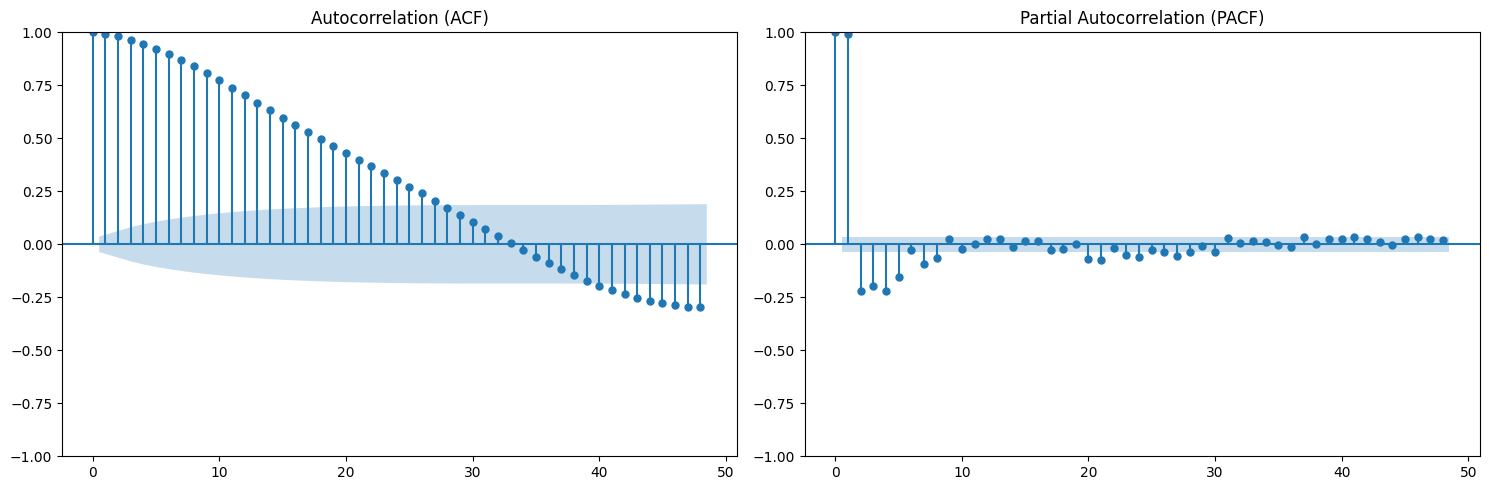

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plot_acf(df_ts['energy_kwh'], lags=48, ax=plt.gca())
plt.title('Autocorrelation (ACF)')

plt.subplot(1, 2, 2)
plot_pacf(df_ts['energy_kwh'], lags=48, ax=plt.gca(), method='ywm')
plt.title('Partial Autocorrelation (PACF)')

plt.tight_layout()
plt.show()

In [15]:
from statsmodels.tsa.stattools import acf, pacf
import numpy as np
from pandas.tseries.frequencies import to_offset

# Determine p and q values from ACF and PACF plots
# - p (AR order): Number of significant lags in PACF before it drops off (cutoff)
# - q (MA order): Number of significant lags in ACF before it drops off (cutoff)

# Estimating p and q visually from the plots (typically, significant lags are those above the confidence interval)
# For automation, we use the number of lags where the autocorrelation is statistically significant

# Prophet expects columns: 'ds' (datetime), 'y' (target)
df_prophet = df[['timestamp', 'energy_kwh']].rename(columns={'timestamp': 'ds', 'energy_kwh': 'y'})

acf_vals = acf(df_ts['energy_kwh'], nlags=48)
pacf_vals = pacf(df_ts['energy_kwh'], nlags=48, method='ywm')

# Find where ACF/PACF values drop below the significance threshold (approx. ±1.96/sqrt(N))
N = len(df_ts['energy_kwh'])
conf_level = 1.96 / np.sqrt(N)

# p: first lag where PACF drops below threshold
p = np.where(np.abs(pacf_vals) < conf_level)[0]
p = p[0] if len(p) > 0 else 0

# q: first lag where ACF drops below threshold
q = np.where(np.abs(acf_vals) < conf_level)[0]
q = q[0] if len(q) > 0 else 0

print(f"Suggested ARIMA orders: p={p}, q={q}")

# Additional feature engineering for Prophet (if not already done)
# (see cell 10 for existing features; let's add more if useful)

# Example: Add holiday/seasonality flags, time since start, etc.
df_prophet['time_since_start'] = (df_prophet['ds'] - df_prophet['ds'].min()).dt.total_seconds() / 3600  # hours since start

# Fourier terms for yearly/weekly seasonality (if needed)

def make_fourier_features(df, colname, period, order):
    t = (df['ds'] - df['ds'].min()).dt.total_seconds() / (period * 3600)
    for i in range(1, order + 1):
        df[f'{colname}_sin_{i}'] = np.sin(2 * np.pi * i * t)
        df[f'{colname}_cos_{i}'] = np.cos(2 * np.pi * i * t)
    return df

# Add weekly seasonality Fourier terms (order=3 as example)
df_prophet = make_fourier_features(df_prophet, 'weekly', period=24*7, order=3)

# Display engineered features
df_prophet.head()

Suggested ARIMA orders: p=6, q=33


,ds,y,time_since_start,weekly_sin_1,weekly_cos_1,weekly_sin_2,weekly_cos_2,weekly_sin_3,weekly_cos_3
0,2025-03-27 12:46:41.558,2.85,0.00,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,2025-03-27 13:01:41.558,2.85,0.25,0.009350,0.999956,0.018699,0.999825,0.028046,0.999607
2,2025-03-27 13:16:41.558,3.00,0.50,0.018699,0.999825,0.037391,0.999301,0.056070,0.998427
3,2025-03-27 13:31:41.558,2.94,0.75,0.028046,0.999607,0.056070,0.998427,0.084051,0.996461
4,2025-03-27 13:46:41.558,2.79,1.00,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712


In [16]:
from statsmodels.tsa.stattools import adfuller

# d: Order of differencing needed to make the series stationary
# If p-value from ADF test is > 0.05, series is non-stationary, so d=1; else d=0
adf_stat, adf_pvalue = adf_result[0], adf_result[1]
if adf_pvalue < 0.05:
    d = 0
else:
    d = 1

print(f"ADF Statistic: {adf_stat}, p-value: {adf_pvalue}")
print(f"Selected differencing order d: {d}")

# p and q are already determined above as p={p}, q={q}
print(f"Selected ARIMA orders: p={p}, d={d}, q={q}")

# Additional temporal parameters
# Frequency of the time series (inferred from timestamp difference)
freq = pd.infer_freq(df['timestamp'])
print(f"Inferred frequency: {freq}")

# Seasonal period (e.g., daily seasonality for hourly data: 24, weekly: 24*7)
# Here, let's check for daily and weekly seasonality
seasonal_periods = {'daily': 24, 'weekly': 24*7}

print("Seasonal periods to consider:", seasonal_periods)

# Store all parameters in a dictionary for easy reference
arima_params = {
    'p': int(p),
    'd': d,
    'q': int(q),
    'frequency': freq,
    'seasonal_periods': seasonal_periods
}

arima_params

ADF Statistic: -9.963991295212095, p-value: 2.3331423737006423e-17
Selected differencing order d: 0
Selected ARIMA orders: p=6, d=0, q=33
Inferred frequency: 15min
Seasonal periods to consider: {'daily': 24, 'weekly': 168}


{'p': 6,
 'd': 0,
 'q': 33,
 'frequency': '15min',
 'seasonal_periods': {'daily': 24, 'weekly': 168}}

In [ ]:
#

In [17]:
# Create a dataset for Prophet and ARIMA model training

# Prophet expects columns: 'ds' (datetime), 'y' (target)
# ARIMA will use the 'y' series, and we can include engineered features for Prophet

# We'll merge the Prophet features (from df_prophet) with ARIMA order info

# Prepare dataset for modeling
model_data = df_prophet.copy()
model_data['arima_p'] = p
model_data['arima_q'] = q

# Display the new dataset with all necessary features
model_data.head()

,ds,y,time_since_start,weekly_sin_1,weekly_cos_1,weekly_sin_2,weekly_cos_2,weekly_sin_3,weekly_cos_3,arima_p,arima_q
0,2025-03-27 12:46:41.558,2.85,0.00,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,6,33
1,2025-03-27 13:01:41.558,2.85,0.25,0.009350,0.999956,0.018699,0.999825,0.028046,0.999607,6,33
2,2025-03-27 13:16:41.558,3.00,0.50,0.018699,0.999825,0.037391,0.999301,0.056070,0.998427,6,33
3,2025-03-27 13:31:41.558,2.94,0.75,0.028046,0.999607,0.056070,0.998427,0.084051,0.996461,6,33
4,2025-03-27 13:46:41.558,2.79,1.00,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,6,33


In [18]:
# Description of features in model_data
feature_descriptions = {
    'ds': 'Timestamp of the observation (datetime).',
    'y': 'Observed energy consumption in kWh (target variable).',
    'time_since_start': 'Elapsed time in hours since the first timestamp.',
    'weekly_sin_1': 'First-order sine Fourier term for weekly seasonality.',
    'weekly_cos_1': 'First-order cosine Fourier term for weekly seasonality.',
    'weekly_sin_2': 'Second-order sine Fourier term for weekly seasonality.',
    'weekly_cos_2': 'Second-order cosine Fourier term for weekly seasonality.',
    'weekly_sin_3': 'Third-order sine Fourier term for weekly seasonality.',
    'weekly_cos_3': 'Third-order cosine Fourier term for weekly seasonality.',
    'arima_p': 'ARIMA model parameter: autoregressive order (p).',
    'arima_q': 'ARIMA model parameter: moving average order (q).'
}

for feature, desc in feature_descriptions.items():
    print(f"{feature}: {desc}")

# Split the data for training and testing (e.g., 80% train, 20% test)
split_idx = int(len(model_data) * 0.8)
train_data = model_data.iloc[:split_idx]
test_data = model_data.iloc[split_idx:]

print(f"\nTraining set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

ds: Timestamp of the observation (datetime).
y: Observed energy consumption in kWh (target variable).
time_since_start: Elapsed time in hours since the first timestamp.
weekly_sin_1: First-order sine Fourier term for weekly seasonality.
weekly_cos_1: First-order cosine Fourier term for weekly seasonality.
weekly_sin_2: Second-order sine Fourier term for weekly seasonality.
weekly_cos_2: Second-order cosine Fourier term for weekly seasonality.
weekly_sin_3: Third-order sine Fourier term for weekly seasonality.
weekly_cos_3: Third-order cosine Fourier term for weekly seasonality.
arima_p: ARIMA model parameter: autoregressive order (p).
arima_q: ARIMA model parameter: moving average order (q).

Training set size: 2308
Test set size: 577


In [19]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model on the training set
# Use only the target variable 'y' for ARIMA
arima_order = (int(p), d, int(q))
arima_model = ARIMA(train_data['y'], order=arima_order)
arima_result = arima_model.fit()

print(arima_result.summary())

c:\Users\omoke\OneDrive\Documents\Studies\Project\streamlit\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\omoke\OneDrive\Documents\Studies\Project\streamlit\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\omoke\OneDrive\Documents\Studies\Project\streamlit\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2308
Model:                ARIMA(6, 0, 33)   Log Likelihood                 249.354
Date:                Mon, 19 May 2025   AIC                           -416.708
Time:                        11:37:22   BIC                           -181.198
Sample:                             0   HQIC                          -330.859
                               - 2308                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2401      0.482      8.805      0.000       3.296       5.184
ar.L1          0.1047      0.431      0.243      0.808      -0.740       0.949
ar.L2          0.2356      0.422      0.558      0.5

ARIMA Model Evaluation on Test Set:
Mean Absolute Error (MAE): 1.6511
Mean Squared Error (MSE): 3.7663
Root Mean Squared Error (RMSE): 1.9407


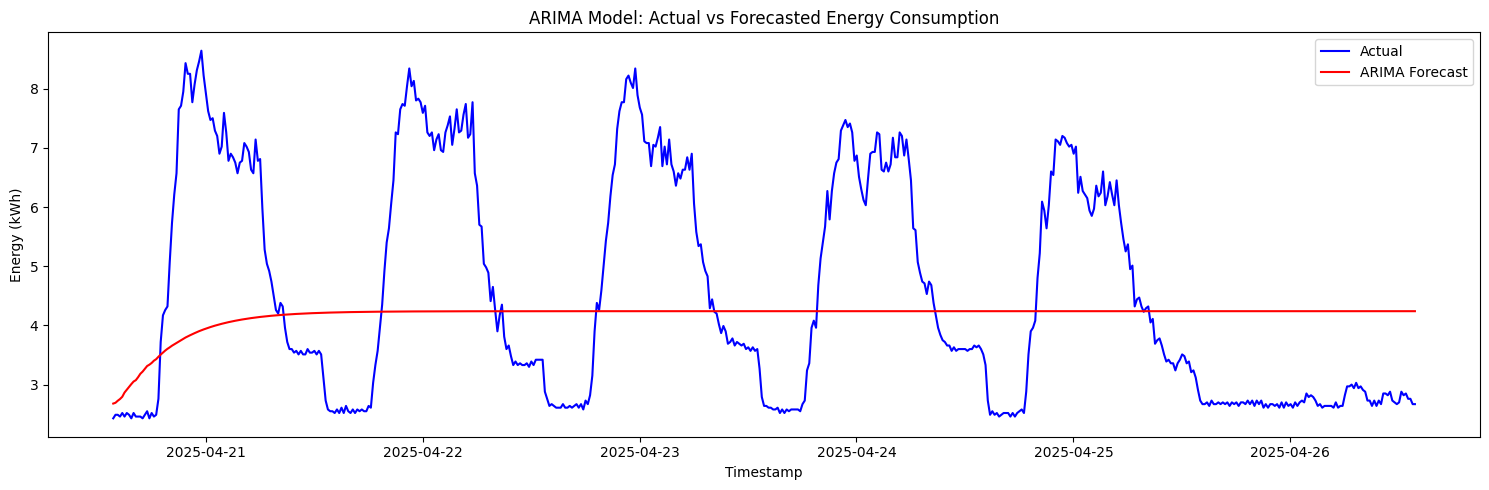

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Generate predictions on the test set
arima_forecast = arima_result.forecast(steps=len(test_data))

# Align indices for comparison
arima_forecast.index = test_data.index

# Calculate evaluation metrics
mse = mean_squared_error(test_data['y'], arima_forecast)
mae = mean_absolute_error(test_data['y'], arima_forecast)
rmse = mse ** 0.5

print(f"ARIMA Model Evaluation on Test Set:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(15, 5))
plt.plot(test_data['ds'], test_data['y'], label='Actual', color='blue')
plt.plot(test_data['ds'], arima_forecast, label='ARIMA Forecast', color='red')
plt.title('ARIMA Model: Actual vs Forecasted Energy Consumption')
plt.xlabel('Timestamp')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Walk-forward validation for ARIMA
history = list(train_data['y'])
predictions = []

for t in range(len(test_data)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test_data['y'].iloc[t])

# Evaluation metrics
mae_wfv = mean_absolute_error(test_data['y'], predictions)
mse_wfv = mean_squared_error(test_data['y'], predictions)
rmse_wfv = mse_wfv ** 0.5

print(f"Walk-forward Validation - MAE: {mae_wfv:.4f}")
print(f"Walk-forward Validation - MSE: {mse_wfv:.4f}")
print(f"Walk-forward Validation - RMSE: {rmse_wfv:.4f}")

# Plot actual vs forecasted
plt.figure(figsize=(15, 5))
plt.plot(test_data['ds'], test_data['y'], label='Actual', color='blue')
plt.plot(test_data['ds'], predictions, label='Walk-forward Forecast', color='green')
plt.title('Walk-forward ARIMA: Actual vs Forecasted Energy Consumption')
plt.xlabel('Timestamp')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.tight_layout()
plt.show()

c:\Users\omoke\OneDrive\Documents\Studies\Project\streamlit\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\omoke\OneDrive\Documents\Studies\Project\streamlit\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\omoke\OneDrive\Documents\Studies\Project\streamlit\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\omoke\OneDrive\Documents\Studies\Project\streamlit\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization 

KeyboardInterrupt: 